In [2]:
import pandas as pd
import seaborn as sns

# Load the Titanic dataset
titanic = sns.load_dataset('titanic')

# Display the first few rows of the dataset
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


Cleean data

In [3]:
titanic.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [4]:
#Missing vals for age col by using mean age
titanic["age"].fillna(titanic["age"].mean(), inplace = True)

#Missing vals for deck with mode
titanic['deck'].fillna(titanic['deck'].mode()[0], inplace = True)

#Mising vals of embark_town with mode
titanic['embark_town'].fillna(titanic['embark_town'].mode()[0], inplace =True)

#Fill embark missing vals with mode
titanic['embarked'].fillna(titanic['embarked'].mode()[0], inplace = True)

In [5]:
titanic.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64

Data Exploration

In [6]:
#stats summary
titanic.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


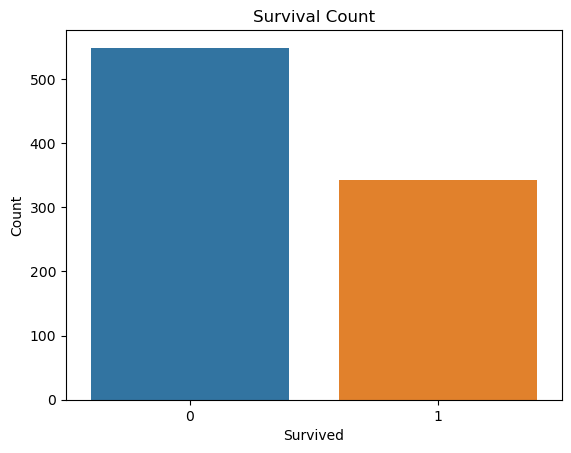

In [8]:
#survivor vs non-survivor count
import matplotlib.pyplot as plt

sns.countplot(data=titanic, x='survived')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Survival Count')
plt.show()

Under the 'survived' column, 0 stands for "not suvived" and 1 stands for "survived". So more persons died than those that survived.

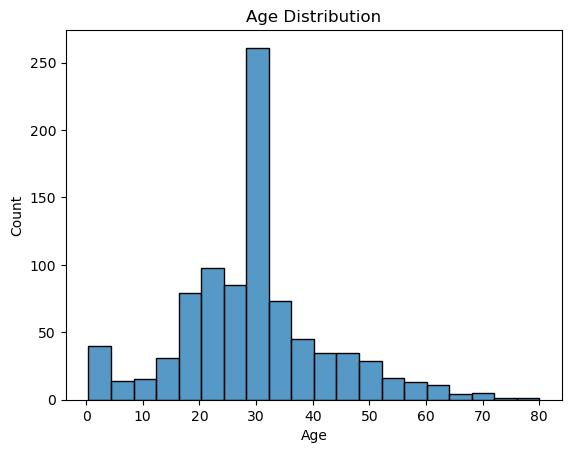

In [9]:
#Passenger age distribution
sns.histplot(data=titanic, x='age', bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')
plt.show()

Persons within the age of 30 died more. Sad...

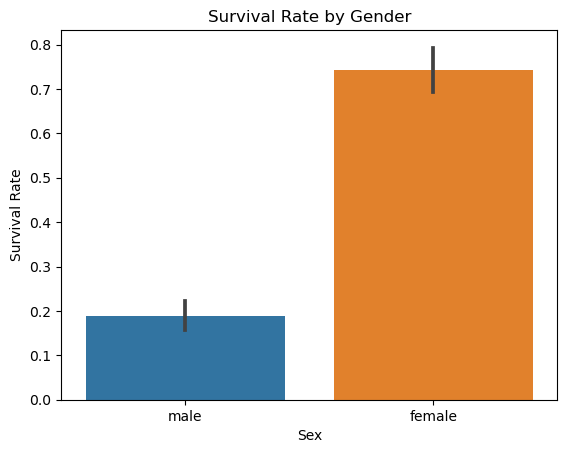

In [10]:
#male vs female survivor rate
sns.barplot(data=titanic, x='sex', y='survived')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Gender')
plt.show()

Hence more women survived(meaning more men died.)

In [32]:
from geopy.geocoders import Nominatim

# Create a geocoder instance
geolocator = Nominatim(user_agent="my_app")

titanic['location'] = None

# Geocode embarkation towns and retrieve latitude and longitude
for index, row in titanic.iterrows():
    embarkation = row['embark_town']
    if embarkation:
        location = geolocator.geocode(embarkation)
        if location:
            titanic.at[index, 'location'] = (location.latitude, location.longitude)

# Print dataframe with the latitude and longitude
print(titanic[['embark_town', 'location']])

     embark_town                  location
0    Southampton   (50.9025349, -1.404189)
1      Cherbourg  (49.6425343, -1.6249565)
2    Southampton   (50.9025349, -1.404189)
3    Southampton   (50.9025349, -1.404189)
4    Southampton   (50.9025349, -1.404189)
..           ...                       ...
886  Southampton   (50.9025349, -1.404189)
887  Southampton   (50.9025349, -1.404189)
888  Southampton   (50.9025349, -1.404189)
889    Cherbourg  (49.6425343, -1.6249565)
890   Queenstown    (-45.0321923, 168.661)

[891 rows x 2 columns]


In [33]:
import folium

# Select the 'embark_town' and 'location' columns
embarkation_data = titanic[['embark_town', 'location']]

# Filter out rows 
embarkation_data = embarkation_data.dropna(subset=['embark_town', 'location'])

# Create a base map centered around the first valid location
if len(embarkation_data) > 0:
    latitude, longitude = embarkation_data['location'].iloc[0]
    base_map = folium.Map(location=[latitude, longitude], zoom_start=5)
else:
    print("No valid embarkation points found in the dataset.")
    exit(1)

# Add markers for embarkation points
for index, row in embarkation_data.iterrows():
    embarkation_city = row['embark_town']
    latitude, longitude = row['location']

    # Create a marker
    marker = folium.Marker(
        location=[latitude, longitude],
        popup=f"Embarkation City: {embarkation_city}",
        icon=folium.Icon(icon='circle', color='blue'),
    )

    # Add marker to base map
    marker.add_to(base_map)

# Display the map
base_map

ah, finally did this one :)

Predictive Model

In [34]:
#To predict of someone survived or not
"""NB the purpose of building a predictive model is not
just to replicate the information that is already available in the dataset,
but rather to create a model that can make predictions on new, unseen data."""

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [35]:
# Select the features and the target variable
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'
data = titanic[features + [target]]

# Preprocess the data
data = pd.get_dummies(data, columns=['sex', 'embarked'], drop_first=True)
data['age'].fillna(data['age'].median(), inplace=True)
data.dropna(inplace=True)

In [38]:
# Split the data into training and testing sets
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)


In [43]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8044692737430168


In [44]:
#Making predictions
sexample_data = X_test.iloc[0].values.reshape(1, -1)
example_prediction = rf_model.predict(example_data)
print("Prediction1:", example_prediction)

example_data_2 = X_test.iloc[1].values.reshape(1, -1)
example_prediction_2 = rf_model.predict(example_data_2)
print("Prediction 2:", example_prediction_2)

example_data_3 = X_test.iloc[2].values.reshape(1, -1)
example_prediction_3 = rf_model.predict(example_data_3)
print('Prediction 3:', example_prediction_3)

example_data_4 = X_test.iloc[3].values.reshape(1, -1)
example_prediction_4 = rf_model.predict(example_data_4)
print('Example Prediction 4:', example_prediction_4)

#NB ) means the person did not survive and 1 means they survived

Prediction1: [0]
Prediction 2: [0]
Prediction 3: [0]
Example Prediction 4: [1]


/home/leong/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/leong/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/leong/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/leong/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
